Below is the code for building a datatset and training a supervised U-net for online image segmentation.

In [14]:
import torch
from torch.utils.data import Dataset
import numpy as np

H, W = 50, 50

s = 50.0 / 80.0
top_row = 22 * s; top_col = 40 * s
top_r_y = 12 * s; top_r_x = 18 * s
bot_row = 55 * s; bot_col = 40 * s
bot_r_y = 12 * s; bot_r_x = 18 * s
cen_row = 38 * s; cen_col = 40 * s
cen_r_y = 10 * s; cen_r_x = 10 * s

# -------------------------------------------------------
# 2. Base image + seed selection (offline static)
# -------------------------------------------------------
def build_base_img_and_seeds(rng):
    img = np.ones((H, W)) * 120
    yy, xx = np.ogrid[:H, :W]

    # base dumbbell
    mask_top = (yy - top_row)**2 / top_r_y**2 + (xx - top_col)**2 / top_r_x**2 <= 1
    img[mask_top] = 60
    mask_bottom = (yy - bot_row)**2 / bot_r_y**2 + (xx - bot_col)**2 / bot_r_x**2 <= 1
    img[mask_bottom] = 60
    mask_center = (yy - cen_row)**2 / cen_r_y**2 + (xx - cen_col)**2 / cen_r_x**2 <= 1
    img[mask_center] = 90

    # seeds BEFORE noise (same logic as your offline code)
    coords_60 = np.argwhere(img == 60)
    coords_90 = np.argwhere(img == 90)
    coords_120 = np.argwhere(img == 120)

    n_fg = 50
    n_bg = 50
    n_bg_90_min = 10

    bg90_indices = rng.choice(len(coords_90), size=n_bg_90_min, replace=False)
    bg_seeds_90 = coords_90[bg90_indices]

    coords_bg_rest = np.vstack([coords_90, coords_120])
    remaining = n_bg - n_bg_90_min
    bg_rest_indices = rng.choice(len(coords_bg_rest), size=remaining, replace=False)
    bg_seeds_rest = coords_bg_rest[bg_rest_indices]

    fg_indices = rng.choice(len(coords_60), size=n_fg, replace=False)
    fg_seeds = [(int(r), int(c)) for r, c in coords_60[fg_indices]]
    bg_seeds = [(int(r), int(c)) for r, c in np.vstack([bg_seeds_90, bg_seeds_rest])]

    return img, np.array(fg_seeds, dtype=int), np.array(bg_seeds, dtype=int)

# -------------------------------------------------------
# 3. Transform image AND seeds together for frame t
#    (seeds are always kept same cardinality via clipping)
# -------------------------------------------------------
def transform_image_and_seeds(t, T_total, fg_seeds_base, bg_seeds_base, rng):
    """
    For frame index t in 0..T_total-1, return:
      - img_noisy_t: transformed, noisy image
      - fg_seeds_t, bg_seeds_t: transformed seeds (int pixel coords), same lengths as base.
    """
    # motion parameters
    tau = t / T_total
    angle_deg = 720 * tau              # 2 full rotations over the clip
    shift_row = 5 * np.sin(2 * np.pi * tau)
    shift_col = 5 * np.cos(2 * np.pi * 1.5 * tau)

    theta = np.deg2rad(angle_deg)
    cos_t, sin_t = np.cos(theta), np.sin(theta)
    cy0, cx0 = cen_row, cen_col  # rotation center

    # transformed dumbbell (analytic)
    img = np.ones((H, W)) * 120
    yy, xx = np.indices((H, W))

    ellipses = [
        (top_row, top_col, top_r_y, top_r_x, 60),
        (bot_row, bot_col, bot_r_y, bot_r_x, 60),
        (cen_row, cen_col, cen_r_y, cen_r_x, 90),
    ]

    for cy, cx, ry, rx, val in ellipses:
        dy = cy - cy0
        dx = cx - cx0
        cy_r = cy0 + cos_t * dy - sin_t * dx + shift_row
        cx_r = cx0 + sin_t * dy + cos_t * dx + shift_col
        mask = ((yy - cy_r) ** 2) / (ry ** 2) + ((xx - cx_r) ** 2) / (rx ** 2) <= 1
        img[mask] = val

    # transform seeds with same rotation+translation, then clip to image bounds
    def transform_seed_array(seeds_base):
        seeds_new = []
        for (r0, c0) in seeds_base:
            dy = r0 - cy0
            dx = c0 - cx0
            r = cy0 + cos_t * dy - sin_t * dx + shift_row
            c = cx0 + sin_t * dy + cos_t * dx + shift_col
            r_i = int(np.round(r))
            c_i = int(np.round(c))
            # clip to valid pixel range
            r_i = min(max(r_i, 0), H - 1)
            c_i = min(max(c_i, 0), W - 1)
            seeds_new.append((r_i, c_i))
        return np.array(seeds_new, dtype=int)

    fg_seeds_t = transform_seed_array(fg_seeds_base)
    bg_seeds_t = transform_seed_array(bg_seeds_base)

    # add noise
    noise = rng.normal(0, 10, (H, W))
    img_noisy = np.clip(img + noise, 0, 255)

    return img_noisy, fg_seeds_t, bg_seeds_t


rng = np.random.default_rng()
img_base, fg_seeds_base, bg_seeds_base = build_base_img_and_seeds(rng)


def transform_image_and_seeds_random(
    t, T_total, fg_base, bg_base, rng
):
    tau = t / T_total

    angle_deg = rng.uniform(360, 1080) * tau
    shift_row = rng.uniform(2, 8) * np.sin(2*np.pi*tau + rng.uniform(0, 2*np.pi))
    shift_col = rng.uniform(2, 8) * np.cos(2*np.pi*1.3*tau + rng.uniform(0, 2*np.pi))

    theta = np.deg2rad(angle_deg)
    cos_t, sin_t = np.cos(theta), np.sin(theta)

    img = np.ones((H, W)) * 120
    yy, xx = np.indices((H, W))

    ellipses = [
        (top_row, top_col, top_r_y, top_r_x, 60),
        (bot_row, bot_col, bot_r_y, bot_r_x, 60),
        (cen_row, cen_col, cen_r_y, cen_r_x, 90),
    ]

    for cy, cx, ry, rx, val in ellipses:
        dy = cy - cen_row
        dx = cx - cen_col
        cy_r = cen_row + cos_t*dy - sin_t*dx + shift_row
        cx_r = cen_col + sin_t*dy + cos_t*dx + shift_col
        mask = ((yy-cy_r)**2)/(ry**2) + ((xx-cx_r)**2)/(rx**2) <= 1
        img[mask] = val

    def transform_seeds(seeds):
        out = []
        for r0, c0 in seeds:
            dy, dx = r0-cen_row, c0-cen_col
            r = cen_row + cos_t*dy - sin_t*dx + shift_row
            c = cen_col + sin_t*dy + cos_t*dx + shift_col
            out.append((int(np.clip(r,0,H-1)), int(np.clip(c,0,W-1))))
        return np.array(out)

    fg = transform_seeds(fg_base)
    bg = transform_seeds(bg_base)

    noise = rng.normal(0, rng.uniform(5,15), (H,W))
    img = np.clip(img + noise, 0, 255)

    return img, fg, bg



In [15]:
class DumbbellDataset(Dataset):
    def __init__(self, n_samples, rng):
        self.n_samples = n_samples
        self.rng = rng

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        # random "time" index
        t = self.rng.integers(0, self.n_samples)

        # ---------------------------------------------------
        # 1. Build transformed dumbbell image (analytic)
        # ---------------------------------------------------
        tau = t / self.n_samples
        angle_deg = 720 * tau
        shift_row = 5 * np.sin(2 * np.pi * tau)
        shift_col = 5 * np.cos(2 * np.pi * 1.5 * tau)

        theta = np.deg2rad(angle_deg)
        cos_t, sin_t = np.cos(theta), np.sin(theta)
        cy0, cx0 = cen_row, cen_col

        yy, xx = np.indices((H, W))
        img = np.ones((H, W)) * 120

        ellipses = [
            (top_row, top_col, top_r_y, top_r_x, 60),
            (bot_row, bot_col, bot_r_y, bot_r_x, 60),
            (cen_row, cen_col, cen_r_y, cen_r_x, 90),
        ]

        for cy, cx, ry, rx, val in ellipses:
            dy = cy - cy0
            dx = cx - cx0
            cy_r = cy0 + cos_t * dy - sin_t * dx + shift_row
            cx_r = cx0 + sin_t * dy + cos_t * dx + shift_col
            mask = ((yy - cy_r) ** 2) / (ry ** 2) + ((xx - cx_r) ** 2) / (rx ** 2) <= 1
            img[mask] = val

        # ---------------------------------------------------
        # 2. Build exact GT mask (pixels with value 60)
        # ---------------------------------------------------
        mask_gt = (img == 60).astype(np.float32)

        # ---------------------------------------------------
        # 3. Add noise to image for NN input (optional)
        # ---------------------------------------------------
        img_noisy = np.clip(img + self.rng.normal(0, 10, (H, W)), 0, 255)
        img_noisy = img_noisy.astype(np.float32) / 255.0

        return (
            torch.from_numpy(img_noisy).unsqueeze(0),  # (1,H,W)
            torch.from_numpy(mask_gt).unsqueeze(0)    # (1,H,W)
        )


class DumbbellDatasetRand(Dataset):
    def __init__(self, n_samples, rng):
        self.n_samples = n_samples
        self.rng = rng

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        # random "time" index
        t = self.rng.integers(0, self.n_samples)

        # ---------------------------------------------------
        # 1. Build transformed dumbbell image (analytic)
        # ---------------------------------------------------
        tau = t / self.n_samples
        angle_deg = self.rng.uniform(360, 1080) * tau
        shift_row = self.rng.uniform(2, 8) * np.sin(2*np.pi*tau + self.rng.uniform(0, 2*np.pi))
        shift_col = self.rng.uniform(2, 8) * np.cos(2*np.pi*1.3*tau + self.rng.uniform(0, 2*np.pi))

        theta = np.deg2rad(angle_deg)
        cos_t, sin_t = np.cos(theta), np.sin(theta)
        cy0, cx0 = cen_row, cen_col

        yy, xx = np.indices((H, W))
        img = np.ones((H, W)) * 120

        ellipses = [
            (top_row, top_col, top_r_y, top_r_x, 60),
            (bot_row, bot_col, bot_r_y, bot_r_x, 60),
            (cen_row, cen_col, cen_r_y, cen_r_x, 90),
        ]

        for cy, cx, ry, rx, val in ellipses:
            dy = cy - cy0
            dx = cx - cx0
            cy_r = cy0 + cos_t * dy - sin_t * dx + shift_row
            cx_r = cx0 + sin_t * dy + cos_t * dx + shift_col
            mask = ((yy - cy_r) ** 2) / (ry ** 2) + ((xx - cx_r) ** 2) / (rx ** 2) <= 1
            img[mask] = val

        # ---------------------------------------------------
        # 2. Build exact GT mask (pixels with value 60)
        # ---------------------------------------------------
        mask_gt = (img == 60).astype(np.float32)

        # ---------------------------------------------------
        # 3. Add noise to image for NN input (optional)
        # ---------------------------------------------------
        img_noisy = np.clip(img + self.rng.normal(0, 10, (H, W)), 0, 255)
        img_noisy = img_noisy.astype(np.float32) / 255.0

        return (
            torch.from_numpy(img_noisy).unsqueeze(0),  # (1,H,W)
            torch.from_numpy(mask_gt).unsqueeze(0)    # (1,H,W)
        )


In [48]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.net(x)

def center_crop(tensor, target):
    _, _, h, w = target.shape
    _, _, H, W = tensor.shape
    dh = (H - h) // 2
    dw = (W - w) // 2
    return tensor[:, :, dh:dh+h, dw:dw+w]
def crop_to_match(tensor, target):
    _, _, h, w = target.shape
    _, _, H, W = tensor.shape
    dh = (H - h) // 2
    dw = (W - w) // 2
    return tensor[:, :, dh:dh+h, dw:dw+w]


class UNetSmall(nn.Module):
    def __init__(self):
        super().__init__()

        self.enc1 = DoubleConv(1, 32)
        self.enc2 = DoubleConv(32, 64)
        self.enc3 = DoubleConv(64, 128)

        self.pool = nn.MaxPool2d(2)

        self.dec2 = DoubleConv(128 + 64, 64)
        self.dec1 = DoubleConv(64 + 32, 32)

        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=False)
        self.outc = nn.Conv2d(32, 1, 1)

    

    def forward(self, x):
        # Encoder
        x1 = self.enc1(x)              # 50×50
        x2 = self.enc2(self.pool(x1))  # 25×25
        x3 = self.enc3(self.pool(x2))  # 12×12 (after floor)

        # Decoder
        x = self.up(x3)                # 24×24
        x2_crop = center_crop(x2, x)
        x = self.dec2(torch.cat([x, x2_crop], dim=1))

        x = self.up(x)                 # 48×48
        x1_crop = center_crop(x1, x)
        x = self.dec1(torch.cat([x, x1_crop], dim=1))

        return torch.sigmoid(self.outc(x))

class UNetMedium(nn.Module):
    def __init__(self):
        super().__init__()

        self.enc1 = DoubleConv(1, 48)
        self.enc2 = DoubleConv(48, 96)
        self.enc3 = DoubleConv(96, 192)

        self.pool = nn.MaxPool2d(2)

        self.dec2 = DoubleConv(192 + 96, 96)
        self.dec1 = DoubleConv(96 + 48, 48)

        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=False)
        self.outc = nn.Conv2d(48, 1, 1)
    

    def forward(self, x):
        # Encoder
        x1 = self.enc1(x)             
        x2 = self.enc2(self.pool(x1))  
        x3 = self.enc3(self.pool(x2))  

        # Decoder
        x = self.up(x3)                
        x2_crop = center_crop(x2, x)
        x = self.dec2(torch.cat([x, x2_crop], dim=1))

        x = self.up(x)              
        x1_crop = center_crop(x1, x)
        x = self.dec1(torch.cat([x, x1_crop], dim=1))

        return torch.sigmoid(self.outc(x))

# dataset = DumbbellDataset(n_samples=3000, rng=np.random.default_rng())
dataset = DumbbellDatasetRand(n_samples=3000, rng=np.random.default_rng())
loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

device = torch.device("cpu")

model = UNetMedium().to(device)
# model = UNetSmall().to(device)
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.BCELoss()

print("UNet params:", sum(p.numel() for p in model.parameters()))

epochs = 20
for ep in range(epochs):
    model.train()
    total = 0.0

    for x, y in loader:
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        pred = model(x)
        y_crop = crop_to_match(y, pred)
        loss = criterion(pred, y_crop)
        loss.backward()
        optimizer.step()

        total += loss.item()

    print(f"Epoch {ep+1}: loss={total/len(loader):.4f}")

torch.save(model.state_dict(), "unet_medium.pt")


UNet params: 1058977
Epoch 1: loss=0.1928
Epoch 2: loss=0.0150
Epoch 3: loss=0.0107
Epoch 4: loss=0.0088
Epoch 5: loss=0.0073
Epoch 6: loss=0.0065
Epoch 7: loss=0.0051
Epoch 8: loss=0.0034
Epoch 9: loss=0.0023
Epoch 10: loss=0.0018
Epoch 11: loss=0.0016
Epoch 12: loss=0.0017
Epoch 13: loss=0.0014
Epoch 14: loss=0.0014
Epoch 15: loss=0.0014
Epoch 16: loss=0.0013
Epoch 17: loss=0.0013
Epoch 18: loss=0.0013
Epoch 19: loss=0.0012
Epoch 20: loss=0.0013


In [49]:
model.eval()

fps = 60
T_sec = 180
n_frames = fps * T_sec

nn_video = []
nn_seg_video = []
with torch.no_grad():
    for t in range(n_frames):
        img, _, _ = transform_image_and_seeds(
            t, n_frames, fg_seeds_base, bg_seeds_base, rng
        )

        img_t = torch.from_numpy(img.astype(np.float32) / 255.0)
        img_t = img_t.unsqueeze(0).unsqueeze(0).to(device)

        pred = model(img_t)
        pred_resized = F.interpolate(pred, size=(H, W), mode='bilinear', align_corners=False)
        seg = (pred_resized[0,0].cpu().numpy() > 0.5).astype(np.float32)
        nn_seg_video.append(seg)
        nn_video.append((img, seg))   # store BOTH



In [50]:
import imageio.v2 as imageio
def img_seg_to_uint8(img, seg):
    out = img * seg
    out = np.clip(out, 0, 255)
    return out.astype(np.uint8)



with imageio.get_writer("unet_segmentation.mp4", fps=fps) as writer:
    for img, seg in nn_video:
        frame = img_seg_to_uint8(img, seg)
        writer.append_data(frame)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (50, 50) to (64, 64) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


In [51]:
import numpy as np

def compute_iou(mask_pred, mask_gt):
    """
    Compute IoU between predicted mask and ground-truth mask.
    mask_pred, mask_gt: np.array of 0/1, same shape
    """
    mask_pred = mask_pred.astype(bool)
    mask_gt = mask_gt.astype(bool)
    
    intersection = np.logical_and(mask_pred, mask_gt).sum()
    union = np.logical_or(mask_pred, mask_gt).sum()
    
    if union == 0:
        return 1.0  # both empty → perfect match
    return intersection / union

fps = 60
T_sec = 180
n_frames = fps * T_sec

gt_video = []       # ground truth masks (0/1)
gt_video_orig = []  # noisy images

rng = np.random.default_rng()

# center of rotation
cy0, cx0 = cen_row, cen_col

yy, xx = np.indices((H, W))

for t in range(n_frames):
    tau = t / n_frames
    angle_deg = 720 * tau
    shift_row = 5 * np.sin(2 * np.pi * tau)
    shift_col = 5 * np.cos(2 * np.pi * 1.5 * tau)

    theta = np.deg2rad(angle_deg)
    cos_t, sin_t = np.cos(theta), np.sin(theta)

    # full dumbbell image (no noise)
    img = np.ones((H, W)) * 120

    ellipses = [
        (top_row, top_col, top_r_y, top_r_x, 60),
        (bot_row, bot_col, bot_r_y, bot_r_x, 60),
        (cen_row, cen_col, cen_r_y, cen_r_x, 90),
    ]

    for cy, cx, ry, rx, val in ellipses:
        dy = cy - cy0
        dx = cx - cx0
        cy_r = cy0 + cos_t * dy - sin_t * dx + shift_row
        cx_r = cx0 + sin_t * dy + cos_t * dx + shift_col
        mask = ((yy - cy_r) ** 2) / (ry ** 2) + ((xx - cx_r) ** 2) / (rx ** 2) <= 1
        img[mask] = val

    # GT mask: pixels exactly with value 60
    mask_gt = (img == 60).astype(np.float32)

    # noisy image for visualization or NN input
    img_noisy = np.clip(img + rng.normal(0, 10, (H, W)), 0, 255)

    gt_video.append(mask_gt)
    gt_video_orig.append(img_noisy)
    
# Now compute IoU per frame for NN
iou_nn = [compute_iou(pred, gt) for pred, gt in zip(nn_seg_video, gt_video)]
mean_iou_nn = np.mean(iou_nn)

# # Compute IoU per frame for your algorithm
# iou_algo = [compute_iou(pred, gt) for pred, gt in zip(algo_seg_video, gt_video)]
# mean_iou_algo = np.mean(iou_algo)

print(f"Mean IoU over video: NN = {mean_iou_nn:.4f}")


Mean IoU over video: NN = 0.9045


In [52]:
def img_mask_to_uint8(img, mask):
    out = img * mask
    out = np.clip(out, 0, 255)
    return out.astype(np.uint8)

with imageio.get_writer("unet_gt.mp4", fps=fps) as writer:
    for img, mask in zip(gt_video_orig, gt_video):  
        frame = img_mask_to_uint8(img, mask)
        writer.append_data(frame)


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (50, 50) to (64, 64) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


In [53]:
def compute_prf(mask_pred, mask_gt, eps=1e-8):
    """
    Compute precision, recall, F1 for a single binary mask.
    mask_pred, mask_gt: np.ndarray of shape (H,W), values 0/1
    """
    mask_pred = mask_pred.astype(bool)
    mask_gt = mask_gt.astype(bool)

    tp = np.logical_and(mask_pred, mask_gt).sum()
    fp = np.logical_and(mask_pred, np.logical_not(mask_gt)).sum()
    fn = np.logical_and(np.logical_not(mask_pred), mask_gt).sum()

    precision = tp / (tp + fp + eps)
    recall = tp / (tp + fn + eps)
    f1 = 2 * precision * recall / (precision + recall + eps)
    return precision, recall, f1

# Lists to store per-frame metrics
precisions, recalls, f1s = [], [], []

# Loop over frames
for pred, gt in zip(nn_seg_video, gt_video):
    p, r, f = compute_prf(pred, gt)
    precisions.append(p)
    recalls.append(r)
    f1s.append(f)

# Average over the video
mean_precision = np.mean(precisions)
mean_recall = np.mean(recalls)
mean_f1 = np.mean(f1s)

print(f"Video Precision: {mean_precision:.4f}")
print(f"Video Recall:    {mean_recall:.4f}")
print(f"Video F1 score:  {mean_f1:.4f}")


Video Precision: 0.9097
Video Recall:    0.9937
Video F1 score:  0.9498


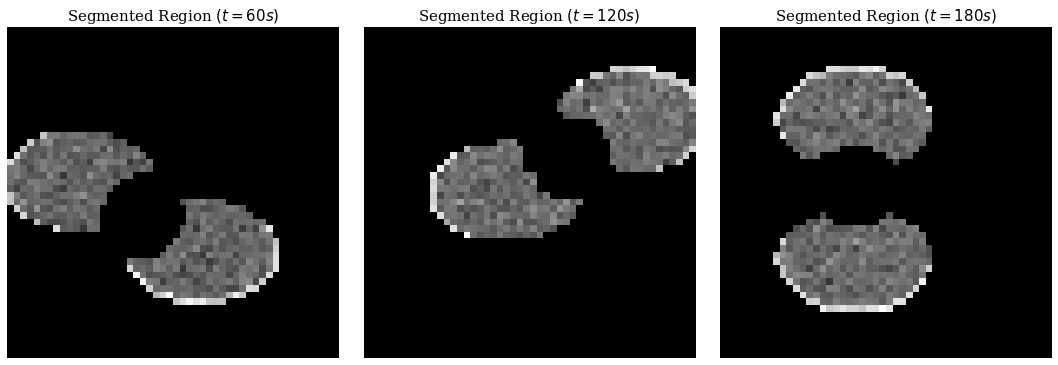

In [54]:
import matplotlib.pyplot as plt
font = {'family': 'serif', 'color':  'black', 'weight': 'normal', 'size': 15}
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(img_mask_to_uint8(nn_video[n_frames//3][0],nn_video[n_frames//3][1]), cmap='gray')
axs[0].set_title(r'Segmented Region $(t = 60s)$',fontdict=font)
axs[1].imshow(nn_video[2*n_frames//3][0]*nn_video[2*n_frames//3][1], cmap='gray')
axs[1].set_title(r'Segmented Region $(t = 120s)$',fontdict=font)
axs[2].imshow(nn_video[-1][0]*nn_video[-1][1], cmap='gray')
axs[2].set_title(r'Segmented Region $(t = 180s)$',fontdict=font)
for ax in axs.flat:
    ax.set_axis_off()

fig.tight_layout()
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42 
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['text.usetex'] = False
plt.savefig('unet_sup.pdf', dpi=300, transparent=False, bbox_inches='tight')